![Churn](Project_1_a.png)

<span style="font-size:24px">**Predicting Customer Churn in a Telecommunications Company**</span>

## Research

### Data Loading

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import catboost

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#### Downloading and Reading Datasets

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

#### Exploring Our Datasets

Let's check for missing values and separate the categorical columns from the numerical columns.

In [3]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [4]:
data_train.shape

(5282, 20)

We have a dataset with 5282 rows and 19 features, where the 20th feature is the target variable "Churn" (indicating whether a customer has left or stayed).

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
data_train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

We don't have any missing values, which is good. However, the 'total spent' column has the object data type instead of float.

In [7]:
data_train['TotalSpent'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5282 entries, 0 to 5281
Series name: TotalSpent
Non-Null Count  Dtype 
--------------  ----- 
5282 non-null   object
dtypes: object(1)
memory usage: 41.4+ KB


Let's examine the values in this column.

In [8]:
data_train['TotalSpent'].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

We observe that there are spaces, indicating missing values or no money spent. Let's replace the spaces with zeros and convert the column to the float data type. We will perform the same steps for the "data_test" dataset as well.

In [9]:
data_train.replace(' ', 0, inplace=True)
data_test.replace(' ', 0, inplace=True)

In [10]:
data_train['TotalSpent'] = data_train['TotalSpent'].astype(float)
data_test['TotalSpent'] = data_train['TotalSpent'].astype(float)

Now let's separate the numerical features from the categorical features and also separate the features from the target variable.

In [11]:
# Numerical features
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Categorical features
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

### Data Analysis

Let's plot histograms for the numerical features.

array([[<AxesSubplot: title={'center': 'ClientPeriod'}>,
        <AxesSubplot: title={'center': 'MonthlySpending'}>],
       [<AxesSubplot: title={'center': 'TotalSpent'}>, <AxesSubplot: >]],
      dtype=object)

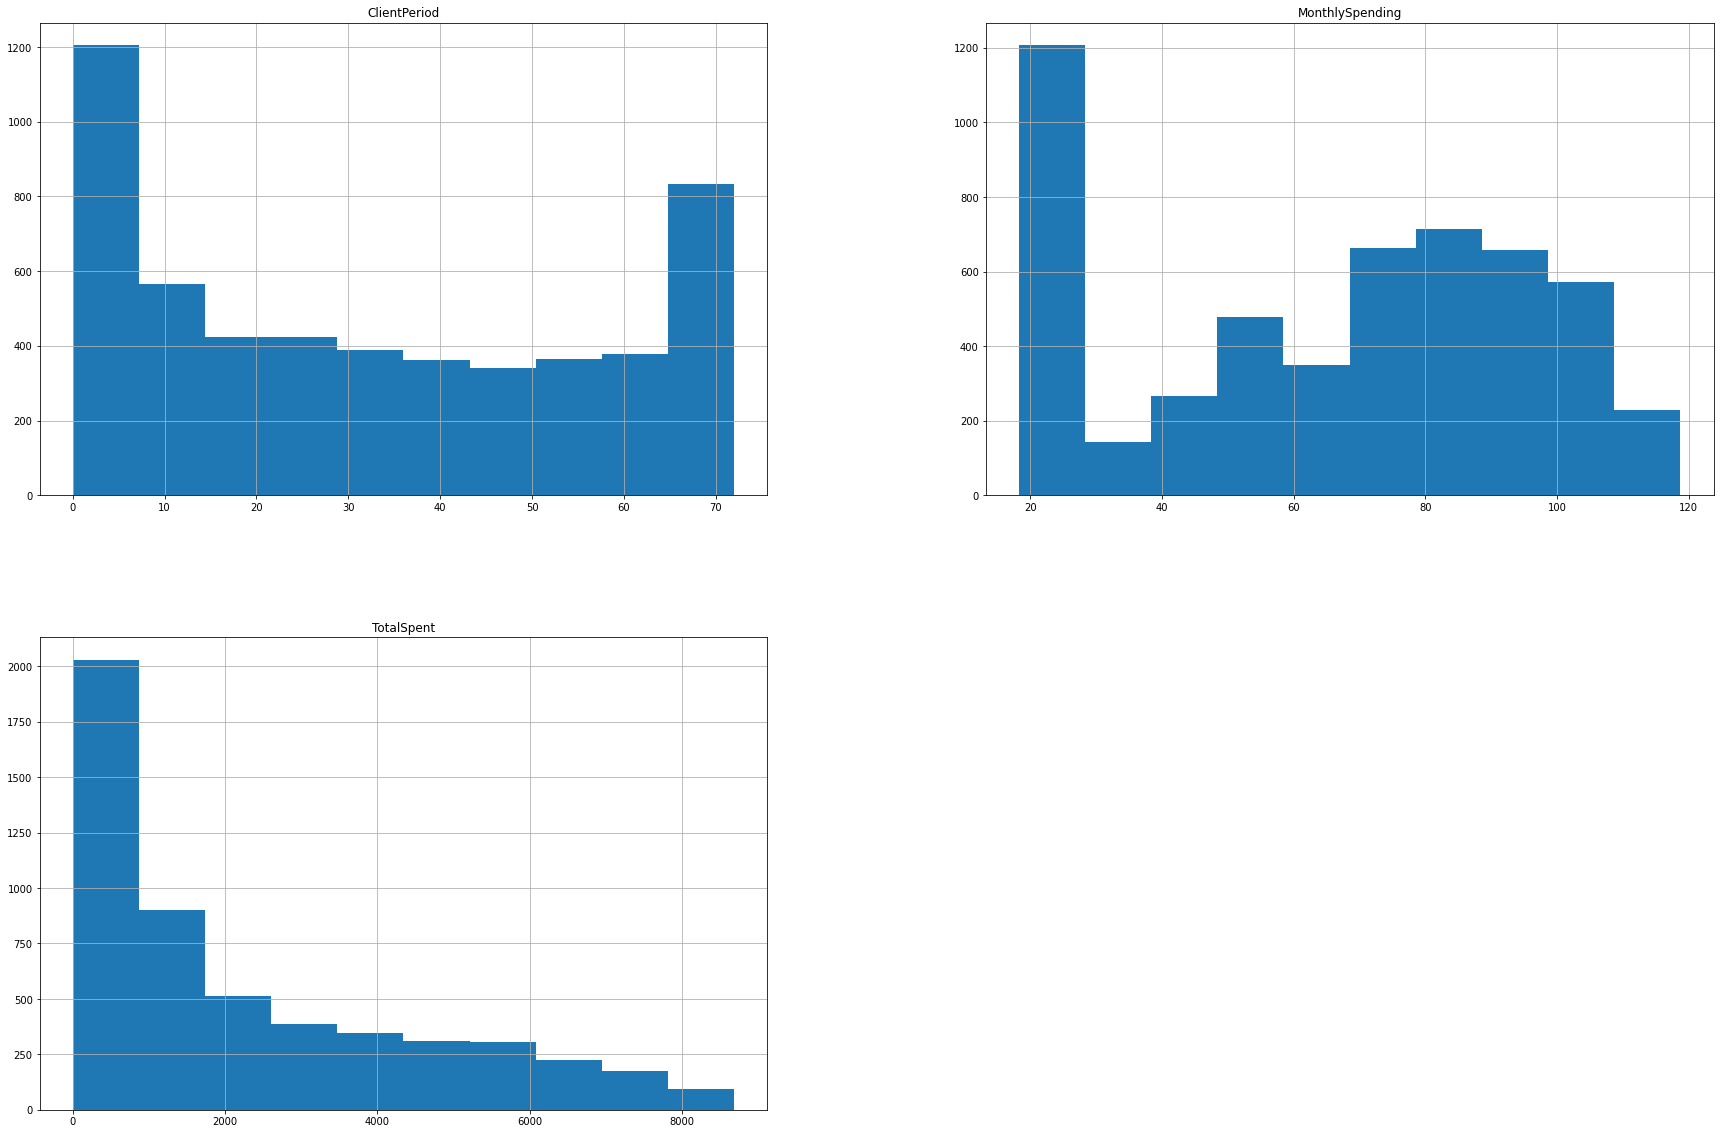

In [12]:
data_train[num_cols].hist(figsize=(30,20))

In the 'client period' feature, we observe the highest number of new subscribers. In second place, we have a significant number of old, loyal subscribers (more than 70 months). Regarding monthly spending, we can see a predominance of cheaper tariffs compared to others. The histogram of 'total spent' exhibits a typical F-distribution, with a large number of individuals having small expenditures and a small number of individuals with total spending above 8000.

Now, let's take a look at the distribution of categorical features.

In [13]:
for index in cat_cols:
    print(data_train[index].value_counts())

Male      2655
Female    2627
Name: Sex, dtype: int64
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64
No     2705
Yes    2577
Name: HasPartner, dtype: int64
No     3676
Yes    1606
Name: HasChild, dtype: int64
Yes    4761
No      521
Name: HasPhoneService, dtype: int64
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64
No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64
No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: int64
No    

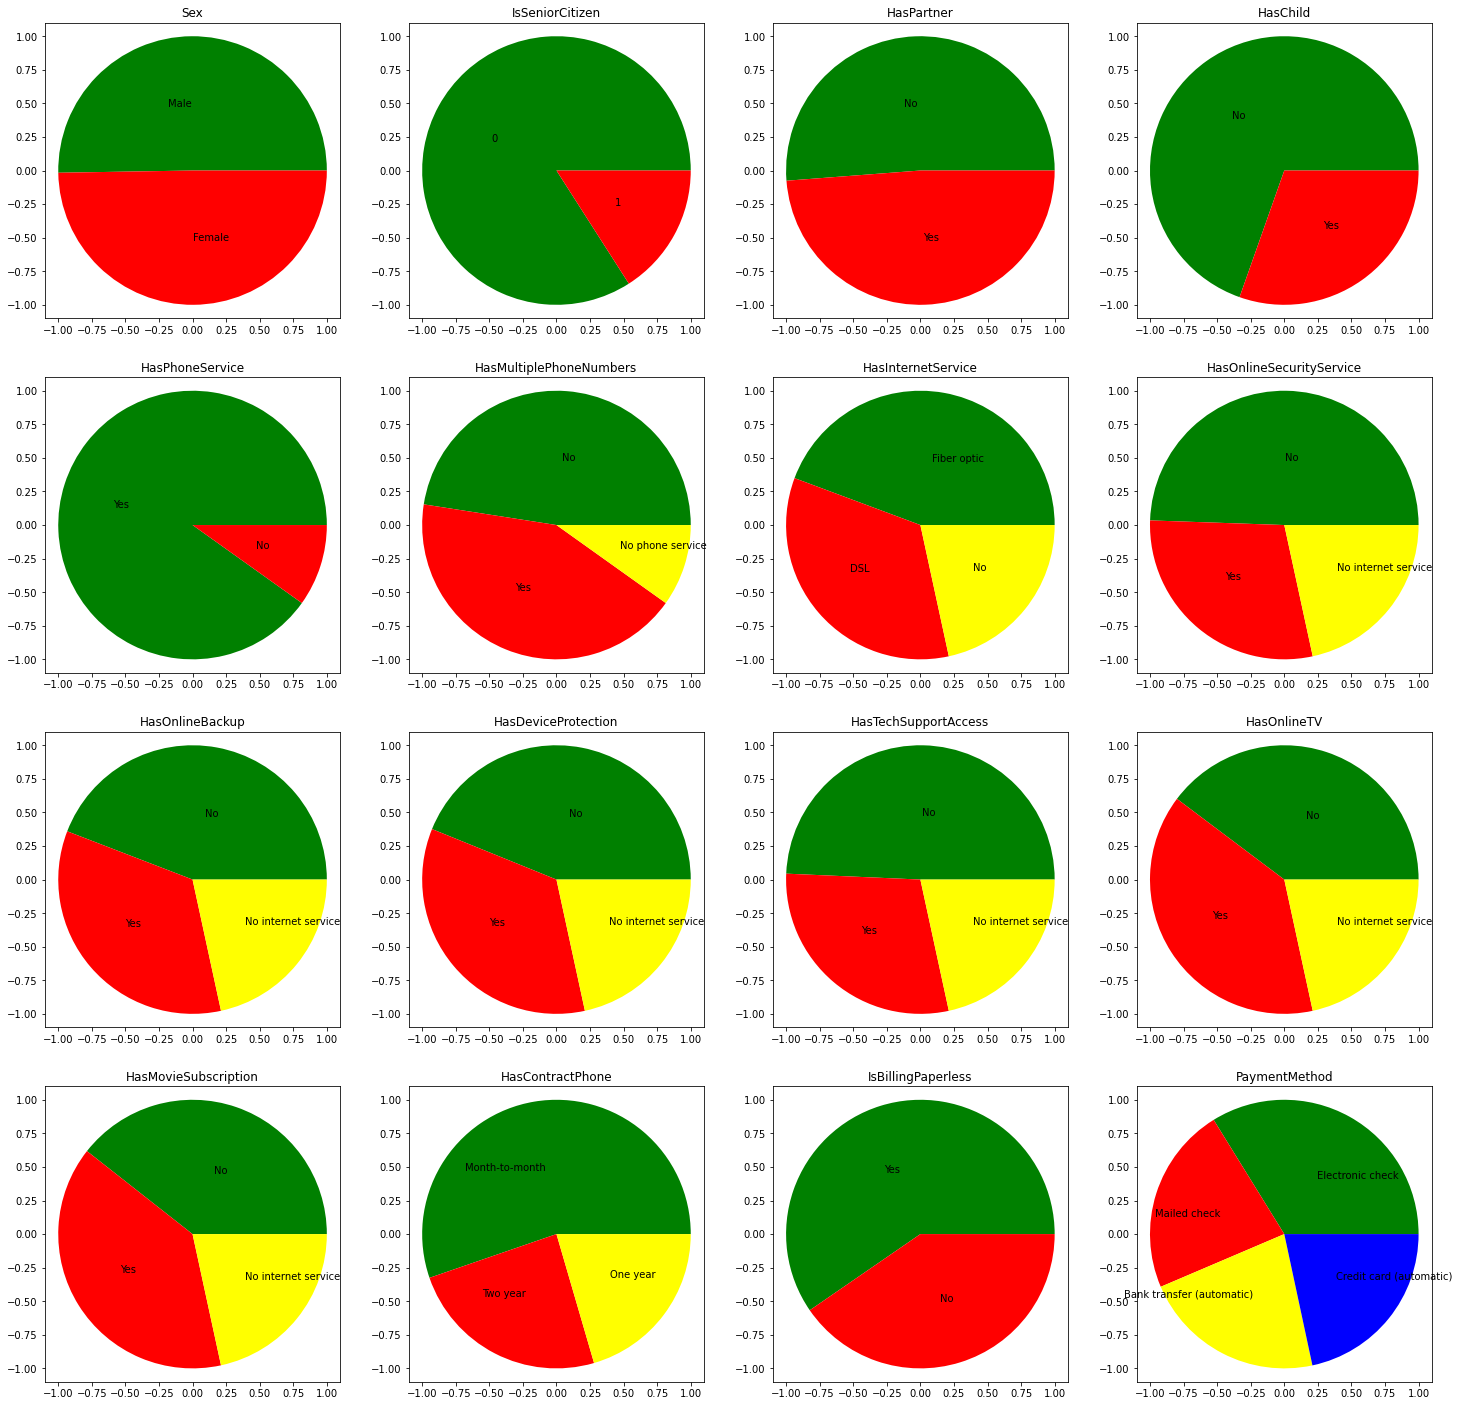

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 25))
ax = axes.ravel()
for i, cat in enumerate(cat_cols):
    x = data_train[cat].value_counts()
    index = x.index
    ax[i].pie(frame=True, x=x, labels=index, colors=['green', 'red', 'yellow', 'blue'], labeldistance = 0.5)
    ax[i].set_title(cat)

We can observe that there is an almost equal distribution of subscribers among males and females. About half of the subscribers have a life partner, and around one-third of them have children. Similar distributions can be seen for features like online TV, access to support, and movie subscriptions.

In [15]:
data_train[target_col].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

([<matplotlib.patches.Wedge at 0x14ef95580>,
 [Text(-0.7478930722742166, 0.8066324766857788, '0'),
  Text(0.7478930722742166, -0.806632476685779, '1')])

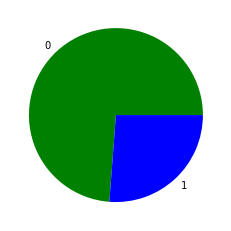

In [16]:
plt.pie(data_train[target_col].value_counts(), labels=['0', '1'], colors=['green', 'blue'])

We can see that the classes are unbalanced, which means that using accuracy as a metric to evaluate models wouldn't make sense.

### Applying Linear Models

Let's train a logistic regression model. To do this, we need to normalize the numerical features and encode the categorical features using one-hot encoding. But before that, let's save copies of the data for gradient boosting.

In [17]:
y_train = data_train[target_col]
X_train = data_train.drop(target_col, axis=1)

In [18]:
linear_data = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols)
    ])

In [19]:
do_pipeline = Pipeline([
        ("preparation", linear_data),
        ("linear", LogisticRegression(solver = 'liblinear', random_state=42))
    ])

Let's tune the parameters and perform cross-validation using GridSearchCV.

In [20]:
C1 = [120, 100, 10, 1, 0.1, 0.01, 0.001]

param_grid = [
        {'linear__penalty':['l1', 'l2'],
         'linear__C':C1
         }
    ]

grid_search1 = GridSearchCV(do_pipeline, param_grid, scoring='roc_auc', verbose=2, refit=True, n_jobs=-1)

In [21]:
grid_search1.fit(data_train[feature_cols], data_train[target_col])

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod'])])),
                                       ('linear',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'linear__C': [120, 100, 10, 1, 0.1, 0.01, 0.001],
                          'linear__penalty': ['l1', 'l2']}],
             scoring='roc_auc', verbose=2)

Let's examine the best parameters and the best score obtained from the GridSearchCV.

In [22]:
grid_search1.best_params_

{'linear__C': 120, 'linear__penalty': 'l1'}

In [23]:
grid_search1.best_score_

0.8451287829199179

0.8451 is a decent score for logistic regression, but there are more precise methods available. Let's try them and see if we can improve the performance.

### Applying Gradient Boosting

Let's proceed with applying CatBoost, a domestic development by Yandex, using the saved unnormalized and uncoded data.

In [24]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = \
train_test_split(X_train.values, y_train.values, train_size=0.8, random_state=42)

Now let's create the dataset objects. The native format for CatBoost is called Pool, which is a class that holds the data. The constructor of the Pool class accepts different parameters.

In [25]:
catboost_train_dataset = catboost.Pool(data=X_train_cat,
                  label=y_train_cat,
                  cat_features=cat_cols,
                  feature_names=feature_cols)

Let's search for the best parameters using grid_search.

In [26]:
cv_classifer = CatBoostClassifier(loss_function = 'Logloss',
                                    random_state = 42,
                                    eval_metric = 'AUC:hints=skip_train~false',
                                    bootstrap_type = 'Bayesian',
                                    verbose = False,
                                    early_stopping_rounds = 300,
                                    )
grid = {"iterations": [100, 200, 300, 500],
        "learning_rate":[0.03, 0.05],
        "max_depth": [4],
        "grow_policy":['Lossguide'],
        "min_data_in_leaf":[100],
        "score_function": ['L2'],}

cb_grid_search = cv_classifer.grid_search(grid, X=catboost_train_dataset)


bestTest = 0.8384122671
bestIteration = 75

0:	loss: 0.8384123	best: 0.8384123 (0)	total: 572ms	remaining: 4s

bestTest = 0.839300092
bestIteration = 86

1:	loss: 0.8393001	best: 0.8393001 (1)	total: 1.02s	remaining: 3.07s

bestTest = 0.8394151139
bestIteration = 192

2:	loss: 0.8394151	best: 0.8394151 (2)	total: 1.94s	remaining: 3.23s

bestTest = 0.8403245054
bestIteration = 199

3:	loss: 0.8403245	best: 0.8403245 (3)	total: 2.84s	remaining: 2.84s

bestTest = 0.8398176904
bestIteration = 299

4:	loss: 0.8398177	best: 0.8403245 (3)	total: 4.19s	remaining: 2.51s

bestTest = 0.8405006326
bestIteration = 286

5:	loss: 0.8405006	best: 0.8405006 (5)	total: 5.55s	remaining: 1.85s

bestTest = 0.840694732
bestIteration = 457

6:	loss: 0.8406947	best: 0.8406947 (6)	total: 7.82s	remaining: 1.12s

bestTest = 0.8405006326
bestIteration = 286

7:	loss: 0.8405006	best: 0.8406947 (6)	total: 10.1s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.8588193142
bestIteration

In [27]:
cb_grid_search['params']

{'min_data_in_leaf': 100,
 'depth': 4,
 'iterations': 500,
 'learning_rate': 0.03,
 'grow_policy': 'Lossguide',
 'score_function': 'L2'}

Let's evaluate the performance using the roc_auc_score.

In [28]:
y_train_predicted = cv_classifer.predict_proba(X_train)[:, 1]
train_searching_auc = roc_auc_score(y_train, y_train_predicted)
train_searching_auc

/usr/local/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0.874555593204756

0.8746 is a very good score indeed. Let's see how it performs on the test dataset.

## Prediction

With a score of 0.87 achieved by CatBoost, it is clearly better than the score of 0.84 from our logistic regression model. Therefore, in this case, the best model is CatBoost. Let's use it to predict customer churn on the test dataset from Kaggle.

In [29]:
y_test_predicted = cv_classifer.predict_proba(data_test)[:, 1]

/usr/local/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Let's write our predictions to a submission file called "submission" and submit it to Kaggle.

In [30]:
submission = pd.read_csv('submission.csv')
submission['Churn'] = y_test_predicted

In [31]:
submission.head()

,Id,Churn
0,0,0.047696
1,1,0.746904
2,2,0.810029
3,3,0.029344
4,4,0.009610


In [32]:
submission.to_csv('DmitriyLyalin_submission.csv', index = False)

[CV] END ..................linear__C=120, linear__penalty=l1; total time=   1.1s
[CV] END ..................linear__C=100, linear__penalty=l2; total time=   0.2s
[CV] END ..................linear__C=100, linear__penalty=l2; total time=   0.2s
[CV] END ...................linear__C=10, linear__penalty=l1; total time=   0.9s
[CV] END ....................linear__C=1, linear__penalty=l1; total time=   0.2s
[CV] END ..................linear__C=0.1, linear__penalty=l1; total time=   0.1s
[CV] END ..................linear__C=0.1, linear__penalty=l2; total time=   0.1s
[CV] END .................linear__C=0.01, linear__penalty=l1; total time=   0.1s
[CV] END ................linear__C=0.001, linear__penalty=l1; total time=   0.1s
[CV] END ..................linear__C=120, linear__penalty=l2; total time=   0.2s
[CV] END ..................linear__C=120, linear__penalty=l2; total time=   0.2s
[CV] END ..................linear__C=100, linear__penalty=l1; total time=   1.2s
[CV] END ...................

https://www.kaggle.com/competitions/advanced-dls-spring-2021/leaderboard?search=lyalin

![Kaggle_score](Project_1.png)

Great job! The score of 0.85066 on Kaggle is a good result. It seems that the model performed well on the test dataset.